### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
%cd /gdrive/MyDrive/Deep_Learning/Homework2/

/gdrive/MyDrive/Deep_Learning/Homework2


### Import libraries

In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Input, Dense, Lambda, Subtract, Add, Reshape
from tensorflow.keras.models import Model
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### N-BEAT Model class 

[Tensorflow implementation](https://github.com/philipperemy/n-beats) of the N-BEATS model architecture (Oreshkin, B.N., Carpov, D., Chapados, N. and Bengio, Y., 2019).  This implementation was written by Philippe Remy and Jean-Sebastien Dhr and is available in the package *nbeats-keras*.

In [4]:
#Original code from : https://github.com/philipperemy/n-beats
class NBeatsNet:
    GENERIC_BLOCK = 'generic'
    TREND_BLOCK = 'trend'
    SEASONALITY_BLOCK = 'seasonality'

    _BACKCAST = 'backcast'
    _FORECAST = 'forecast'

    def __init__(self,
                 input_dim=1,
                 exo_dim=0,
                 backcast_length=10,
                 forecast_length=2,
                 stack_types=(TREND_BLOCK, SEASONALITY_BLOCK),
                 nb_blocks_per_stack=3,
                 thetas_dim=(4, 8),
                 share_weights_in_stack=False,
                 hidden_layer_units=256,
                 nb_harmonics=None):

        self.stack_types = stack_types
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.thetas_dim = thetas_dim
        self.units = hidden_layer_units
        self.share_weights_in_stack = share_weights_in_stack
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.input_dim = input_dim
        self.exo_dim = exo_dim
        self.input_shape = (self.backcast_length, self.input_dim)
        self.exo_shape = (self.backcast_length, self.exo_dim)
        self.output_shape = (self.forecast_length, self.input_dim)
        self.weights = {}
        self.nb_harmonics = nb_harmonics
        assert len(self.stack_types) == len(self.thetas_dim)

        x = Input(shape=self.input_shape, name='input_variable')
        x_ = {}
        for k in range(self.input_dim):
            x_[k] = Lambda(lambda z: z[..., k])(x)
        e_ = {}
        if self.has_exog():
            e = Input(shape=self.exo_shape, name='exos_variables')
            for k in range(self.exo_dim):
                e_[k] = Lambda(lambda z: z[..., k])(e)
        else:
            e = None
        y_ = {}

        for stack_id in range(len(self.stack_types)):
            stack_type = self.stack_types[stack_id]
            nb_poly = self.thetas_dim[stack_id]
            for block_id in range(self.nb_blocks_per_stack):
                backcast, forecast = self.create_block(x_, e_, stack_id, block_id, stack_type, nb_poly)
                for k in range(self.input_dim):
                    x_[k] = Subtract()([x_[k], backcast[k]])
                    if stack_id == 0 and block_id == 0:
                        y_[k] = forecast[k]
                    else:
                        y_[k] = Add()([y_[k], forecast[k]])

        for k in range(self.input_dim):
            y_[k] = Reshape(target_shape=(self.forecast_length, 1))(y_[k])
            x_[k] = Reshape(target_shape=(self.backcast_length, 1))(x_[k])
        if self.input_dim > 1:
            y_ = Concatenate()([y_[ll] for ll in range(self.input_dim)])
            x_ = Concatenate()([x_[ll] for ll in range(self.input_dim)])
        else:
            y_ = y_[0]
            x_ = x_[0]

        if self.has_exog():
            n_beats_forecast = Model([x, e], y_, name=self._FORECAST)
            n_beats_backcast = Model([x, e], x_, name=self._BACKCAST)
        else:
            n_beats_forecast = Model(x, y_, name=self._FORECAST)
            n_beats_backcast = Model(x, x_, name=self._BACKCAST)

        self.models = {model.name: model for model in [n_beats_backcast, n_beats_forecast]}
        self.cast_type = self._FORECAST

    def has_exog(self):
        # exo/exog is short for 'exogenous variable', i.e. any input
        # features other than the target time-series itself.
        return self.exo_dim > 0

    @staticmethod
    def load(filepath, custom_objects=None, compile=True):
        from tensorflow.keras.models import load_model
        return load_model(filepath, custom_objects, compile)

    def _r(self, layer_with_weights, stack_id):
        if self.share_weights_in_stack:
            layer_name = layer_with_weights.name.split('/')[-1]
            try:
                reused_weights = self.weights[stack_id][layer_name]
                return reused_weights
            except KeyError:
                pass
            if stack_id not in self.weights:
                self.weights[stack_id] = {}
            self.weights[stack_id][layer_name] = layer_with_weights
        return layer_with_weights

    def create_block(self, x, e, stack_id, block_id, stack_type, nb_poly):
        def reg(layer):
            return self._r(layer, stack_id)

        def n(layer_name):
            return '/'.join([str(stack_id), str(block_id), stack_type, layer_name])

        backcast_ = {}
        forecast_ = {}
        d1 = reg(Dense(self.units, activation='relu', name=n('d1')))
        d2 = reg(Dense(self.units, activation='relu', name=n('d2')))
        d3 = reg(Dense(self.units, activation='relu', name=n('d3')))
        d4 = reg(Dense(self.units, activation='relu', name=n('d4')))
        if stack_type == 'generic':
            theta_b = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_b')))
            theta_f = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_f')))
            backcast = reg(Dense(self.backcast_length, activation='linear', name=n('backcast')))
            forecast = reg(Dense(self.forecast_length, activation='linear', name=n('forecast')))
        elif stack_type == 'trend':
            theta_f = theta_b = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_f_b')))
            backcast = Lambda(trend_model, arguments={'is_forecast': False, 'backcast_length': self.backcast_length,
                                                      'forecast_length': self.forecast_length})
            forecast = Lambda(trend_model, arguments={'is_forecast': True, 'backcast_length': self.backcast_length,
                                                      'forecast_length': self.forecast_length})
        else:  # 'seasonality'
            if self.nb_harmonics:
                theta_b = reg(Dense(self.nb_harmonics, activation='linear', use_bias=False, name=n('theta_b')))
            else:
                theta_b = reg(Dense(self.forecast_length, activation='linear', use_bias=False, name=n('theta_b')))
            theta_f = reg(Dense(self.forecast_length, activation='linear', use_bias=False, name=n('theta_f')))
            backcast = Lambda(seasonality_model,  
                              arguments={'is_forecast': False, 'backcast_length': self.backcast_length,
                                         'forecast_length': self.forecast_length})
            forecast = Lambda(seasonality_model,
                              arguments={'is_forecast': True, 'backcast_length': self.backcast_length,
                                         'forecast_length': self.forecast_length})
        for k in range(self.input_dim):
            if self.has_exog():
                d0 = Concatenate()([x[k]] + [e[ll] for ll in range(self.exo_dim)])
            else:
                d0 = x[k]
            d1_ = d1(d0)
            d2_ = d2(d1_)
            d3_ = d3(d2_)
            d4_ = d4(d3_)
            theta_f_ = theta_f(d4_)
            theta_b_ = theta_b(d4_)
            backcast_[k] = backcast(theta_b_)
            forecast_[k] = forecast(theta_f_)

        return backcast_, forecast_

    def __getattr__(self, name):
        attr = getattr(self.models[self._FORECAST], name)

        if not callable(attr):
            return attr

        def wrapper(*args, **kwargs):
            cast_type = self._FORECAST
            if attr.__name__ == 'predict' and 'return_backcast' in kwargs and kwargs['return_backcast']:
                del kwargs['return_backcast']
                cast_type = self._BACKCAST
            return getattr(self.models[cast_type], attr.__name__)(*args, **kwargs)

        return wrapper


def linear_space(backcast_length, forecast_length, is_forecast=True):
    ls = K.arange(-float(backcast_length), float(forecast_length), 1) / forecast_length
    return ls[backcast_length:] if is_forecast else K.abs(K.reverse(ls[:backcast_length], axes=0))


def seasonality_model(thetas, backcast_length, forecast_length, is_forecast):
    p = thetas.get_shape().as_list()[-1]
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    t = linear_space(backcast_length, forecast_length, is_forecast=is_forecast)
    s1 = K.stack([K.cos(2 * np.pi * i * t) for i in range(p1)])
    s2 = K.stack([K.sin(2 * np.pi * i * t) for i in range(p2)])
    if p == 1:
        s = s2
    else:
        s = K.concatenate([s1, s2], axis=0)
    s = K.cast(s, np.float32)
    return K.dot(thetas, s)


def trend_model(thetas, backcast_length, forecast_length, is_forecast):
    p = thetas.shape[-1]
    t = linear_space(backcast_length, forecast_length, is_forecast=is_forecast)
    t = K.transpose(K.stack([t ** i for i in range(p)]))
    t = K.cast(t, np.float32)
    return K.dot(thetas, K.transpose(t))

### Set seed for reproducibility

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Exploration Data Analysis (EDA)

Load the dataset

In [6]:
dataset = pd.read_csv('training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


Sequential Train-Test split and normalization

(63528, 7) (5000, 7)


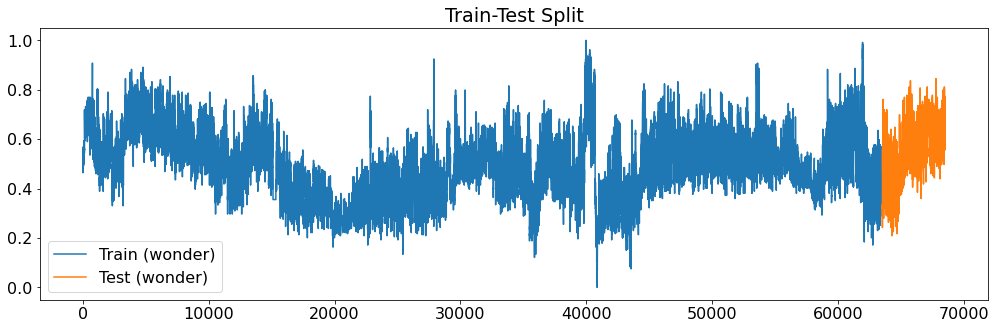

In [7]:
test_size =  5000                   
X_train_raw = dataset.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize data
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)   #Min-Max scaling
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)    #Min-Max scaling


#Plot  the Wonder level TS
plt.figure(figsize=(17,5))
plt.plot(X_train_raw['Wonder level'], label='Train (wonder)')
plt.plot(X_test_raw['Wonder level'], label='Test (wonder)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

## N-BEATS Univariate models

We train 7 distinct univariate N-BEATS models. Each model takes one time series as input. 

It takes about 5 minutes to train the 7 models, without  GPU.

In [8]:
#Best parameter values for window and stride obtained after local experiments
window =  1500 
stride = 10 

#Required forecast horizon for the competition
telescope = 864   

#Index of target labels
target_labels = dataset.columns

In [9]:
future = dataset.iloc[-window:]  
future = (future-X_min)/(X_max-X_min)  
future = np.expand_dims(future, axis=0)
future.shape

(1, 1500, 7)

In [10]:
#New indexes are  created. One for each time series. 
Spong = pd.Index([target_labels[0]])
Wonder = pd.Index([target_labels[1]])
Crunch = pd.Index([target_labels[2]])
Loud = pd.Index([target_labels[3]])
Meme =pd.Index([target_labels[4]])   
Soap = pd.Index([target_labels[5]])  
Hype = pd.Index([target_labels[6]])  

In [11]:
def build_sequences(df, 
                    target_labels, 
                    window=1500, 
                    stride=20, 
                    telescope=864):  

    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window   

    if(padding_len != 0):
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')  
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):  
        dataset.append(temp_df[idx:idx+window]) 
        labels.append(temp_label[idx+window:idx+window+telescope]) 

    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

In [12]:
def N_BEATS_training(column_list, 
                     X_train_raw, 
                     X_test_raw,
                     window,
                     stride,
                     telescope, 
                     future, 
                     epochs = [50,50,50,50,50,50,50]  
                     ):
  

  #Initialization with the first time series
  iter = 0
  print("iteration %s ,  column %s"%(iter,column_list[0]))
  
  #Build a sequence for the first time series only
  X_train, y_train = build_sequences(X_train_raw, column_list[0], window, stride, telescope)
  X_test, y_test = build_sequences(X_test_raw, column_list[0], window, stride, telescope)
  #Control the shapes
  print(X_train.shape, y_train.shape,X_test.shape, y_test.shape)
  print(" ")

  #Create NBEATS model
  model = NBeatsNet(
            backcast_length=window, 
            forecast_length= telescope,
            stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
            nb_blocks_per_stack=1, 
            thetas_dim=(4, 8), 
            share_weights_in_stack=True,
            hidden_layer_units=64
        )
  #Compile the model
  model.compile(loss='mse', optimizer='adam')
  print('Training...')
  history = model.fit(X_train[:,:,iter], 
                      y_train, validation_split=.2,  
          callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
          tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
          ], 
          epochs=epochs[0], 
          batch_size=64).history 

  #Save the trained model
  #model.save('saved_models/N-BEATS_model_%s'%column_list[0][0])

  #Make predictions on the test set
  predictions = model.predict(X_test)
  mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
  mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
  print(mean_squared_error, mean_absolute_error)

  #Forecast future values
  future_predictions = model.predict(future[:,:,iter]) 
  
  iter +=1


  #Main Loop : model training and forecast for the 6 other time series
  for col in column_list[1:]:
    print("iteration %s ,  column %s"%(iter,col[0]))
    
    X_train, y_train = build_sequences(X_train_raw, col, window, stride, telescope)
    X_test, y_test = build_sequences(X_test_raw, col, window, stride, telescope)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    print(" ")
    
    #Create NBEATS model
    model = NBeatsNet(
            backcast_length=window, 
            forecast_length= telescope,
            stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
            nb_blocks_per_stack=1,
             thetas_dim=(4, 8), 
             share_weights_in_stack=True,
            hidden_layer_units=64
        )
    #Compile the model
    model.compile(loss='mse', optimizer='adam')
    print('Training...')
    history = model.fit(X_train[:,:,iter], 
                        y_train, validation_split=.2,
          callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
          tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
          ], 
          epochs=epochs[iter], 
          batch_size=64).history
    #model.save('saved_models/N-BEATS_model_%'%column_list[iter][0])

    #Make predictions on the test set
    pred = model.predict(X_test)
    #Append the prediction to the ones made for the previous time series
    predictions = np.dstack((predictions,pred))
    mean_squared_error = tfk.metrics.mse(y_test.flatten(),pred.flatten())
    mean_absolute_error = tfk.metrics.mae(y_test.flatten(),pred.flatten())
    print(mean_squared_error, mean_absolute_error)

    #Forecast future values
    future_pred = model.predict(future[:,:,iter]) 
    #Append the forecast values to the ones made for the previous time series
    future_predictions = np.dstack((future_predictions, future_pred))

    iter +=1
    
  
  return predictions, future_predictions


In [ ]:
%%time
column_list = [Spong, Wonder, Crunch, Loud, Meme, Soap, Hype]
predictions, future_predictions = N_BEATS_training(column_list, X_train_raw, X_test_raw, window, stride, telescope, future)

In [14]:
#Control the shape of the predictions, should be (364, 864, 7)
predictions.shape  

(364, 864, 7)

In [15]:
#Control the shape of the forecast, should be (1, 864, 7)
future_predictions.shape 

(1, 864, 7)

## Test set evaluation

In [16]:
def inspect_multivariate_prediction(X_train_raw,
                                    X_test_raw, 
                                    pred, 
                                    columns_list, 
                                    window, 
                                    stride,
                                    telescope, 
                                    idx=None):
  
    if(idx==None):
        idx=np.random.randint(0,457)

    figs, axs = plt.subplots(len(columns_list), 1, sharex=True, figsize=(17,17))
    i = 0
    for col in columns_list:
      X_train, y_train = build_sequences(X_train_raw, col, window, stride, telescope)    
      X_test, y_test = build_sequences(X_test_raw, col, window, stride, telescope)
      axs[i].plot(np.arange(len(X_test[0,:,i])), X_test[idx,:,i])
      axs[i].plot(np.arange(len(X_test[0,:,i]), len(X_train[0,:,i])+telescope), y_test[idx,:,0], color='orange')
      axs[i].plot(np.arange(len(X_test[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
      axs[i].set_title(col[0])
      axs[i].set_ylim(0,1)
      i +=1
    plt.show()

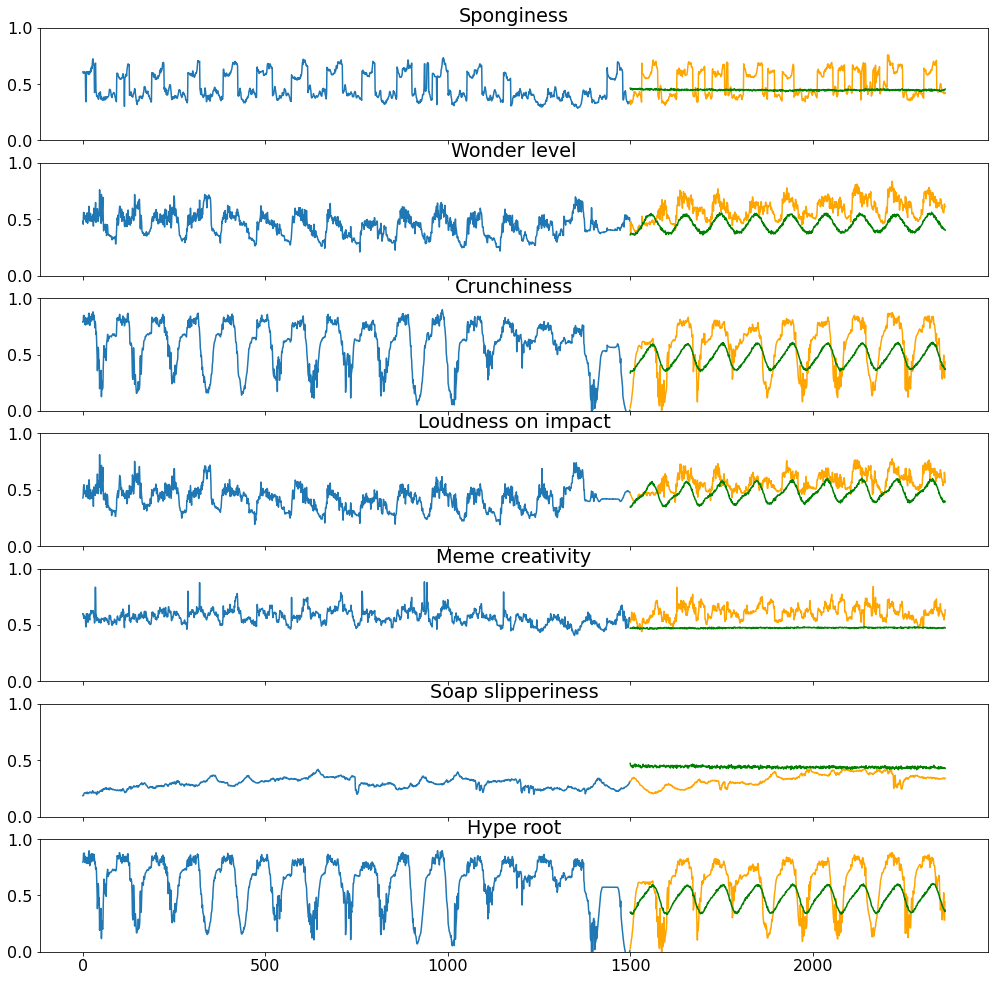

In [17]:
inspect_multivariate_prediction(X_train_raw,X_test_raw, predictions, column_list, window, stride, telescope)

## Predict the future 

In [18]:
X_test, y_test = build_sequences(X_test_raw, dataset.columns, window, stride, telescope)

maes = []

for i in range(predictions.shape[1]):
    ft_maes = []
   
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)




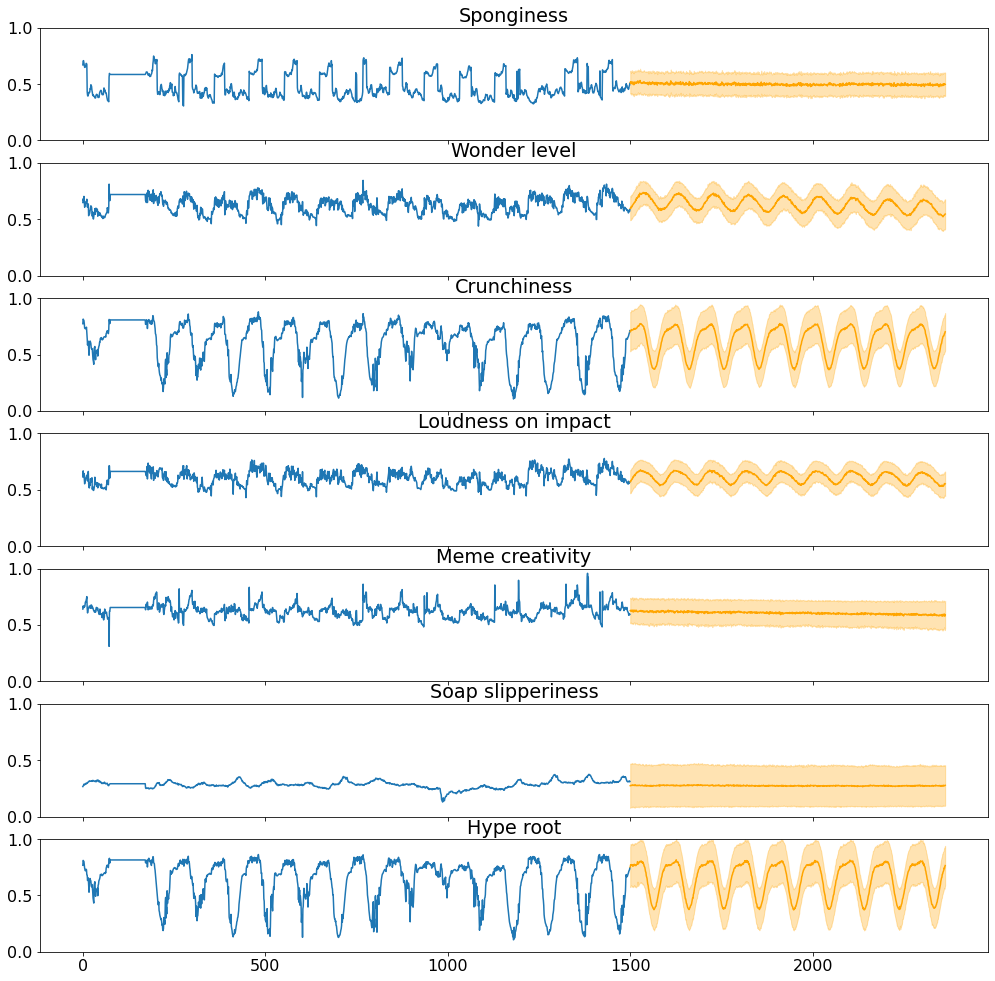

In [20]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()